# PROJECT : CIFAR-10 이미지 생성하기

---
## 개요
이전 예제에서 fasion mnist 데이터셋으로 만들어봤던 DGGAN 모델과 같이 CIFAR-10 데이터셋으로 DGGAN 모델을 만들어본다.  
CIFAR-10 데이터셋으로 모델을 학습 시킬 때에는 주의해야할 점이 있다.  
* 이미지 데이터의 shape이 (28, 28, 1)에서 (32, 32, 3)으로 변경이 되므로, 생성자 및 판별자 모델의 입출력 형상과 모델 구조가 변경되니 이 점을 주의한다.
* 이미지가 단색의 grayscale에서 RGB 3채널의 컬러 이미지로 변경이 되므로, 시각화 과정에서 이 점을 참고한다.
* 입력 데이터 전체 차원이 3~4배 증가하면서, 학습이 진행되는 양상이 다소 달라진다.

<br>

## 목차
1. 주요 라이브러리 불러오기 및 버전 확인
2. 작업환경 구성하기
3. 데이터셋 구성하기
4. 생성자 모델 구현하기
5. 판별자 모델 구현하기
6. 손실함수와 최적화 함수 구현하기
7. 훈련과정 상세 기능 구현하기
8. 학습 과정 진행하기
9. (optional)GAN 훈련 과정 개선하기

### STEP 1. 주요 라이브러리 불러오기 및 버전 확인
---
DGGAN 모델을 구현하는 데에 필요한 라이브러리를 미리 확인하고 라이브러리 버전 간 충돌에 대비하여 충돌 가능성이 있는 라이브러리의 버전을 확인한다.

In [1]:
# 파일 경로 접근을 위한 시스템 라이브러리
import os
# 전역변수 사용을 위한 시스템 라이브러리
import glob
# 시간 데이터 사용을 위한 시스템 라이브러리
import time

# 이미지 시각화를 위한 라이브러리
import PIL
# gif 생성을 위한 라이브러리
import imageio
# 연산을 위한 라이브러리
import numpy as np
# 텐서 관리를 위한 라이브러리
import tensorflow as tf
# 모델 설계를 위한 라이브러리
from tensorflow.keras import layers

# 데이터 시각화를 위한 라이브러리
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

# 텐서플로우 버전 학인
print("tensorflow", tf.__version__)
print("imageio", imageio.__version__)

tensorflow 2.6.0
imageio 2.9.0


### STEP 2. 작업환경 구성하기
---
프로젝트를 시작하기 전에 미리 아래의 경로에 필요한 디렉터리를 구성했으므로 넘어가도록 한다.
```
$ mkdir -p ~/aiffel/dcgan_newimage/cifar10/generated_samples
$ mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_checkpoints
$ mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_history
```

### STEP 3. 데이터셋 구성하기
---
CIFAR-10 데이터셋은 `tf.keras` 안에 있는 `datasets`에 포함이 되어있으므로, 코드를 작성하여 데이터셋을 불러오도록 한다.

In [2]:
# CIFAR-10 데이터셋 불러오기
cifar10 = tf.keras.datasets.cifar10

# 불러온 데이터셋을 학습용/검증용 데이터로 분리
(train_x, _), (test_x, _) = cifar10.load_data()

# 학습용 데이터 형상 확인
train_x.shape

(50000, 32, 32, 3)

DGGAN 모델은 이미지 분류가 아닌 이미지 생성 모델이기 때문에 별도의 정답 레이블이 불필요하다. 그러므로 정답 레이블에 해당하는 train_y, test_y는 언더스코어 처리를 하도록 한다.  
fasion mnist와는 다르게 이미지의 형상이 32X32 크기의 컬러 이미지 50,000장인 것을 확인할 수 있다.

In [3]:
# 학습 데이터의 픽셀 최댓값 확인
print("max pixel:", train_x.max())
# 학습 데이터의 픽셀 최솟값 확인
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


데이터 전처리를 위해 이미지 픽셀값의 최댓값과 최솟값을 확인한다.  
최댓값이 255, 최솟값이 0이므로 모든 픽셀이 -1 ~ 1 사이의 값이 되도록 정규화를 진행해본다.

In [4]:
# 픽셀 값 정규화 진행
train_x = (train_x - 127.5) / 127.5

# 정규화 진행 후, 픽셀 최댓값 확인
print("max pixel:", train_x.max())
# 정규화 진행 후, 픽셀 최솟값 확인
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


CIFAR-10 데이터셋은 컬러 이미지이기때문에 픽셀값이 -1 ~ 1 사이가 되도록 정규화를 진행한다.
출력 결과를 보면 최댓값이 1, 최솟값이 -1으로 모든 픽셀값이 -1 ~ 1 사이의 값으로 정규화가 진행된 것을 확인 할 수 있다.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


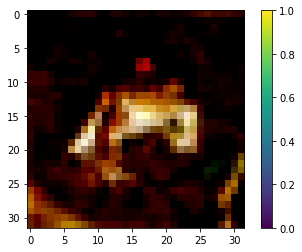

In [5]:
# 학습 데이터 0번째 인덱스 이미지 확인
plt.imshow(train_x[0])
# 컬러 별 픽셀 값 확인
plt.colorbar()
# 이미지 보기
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

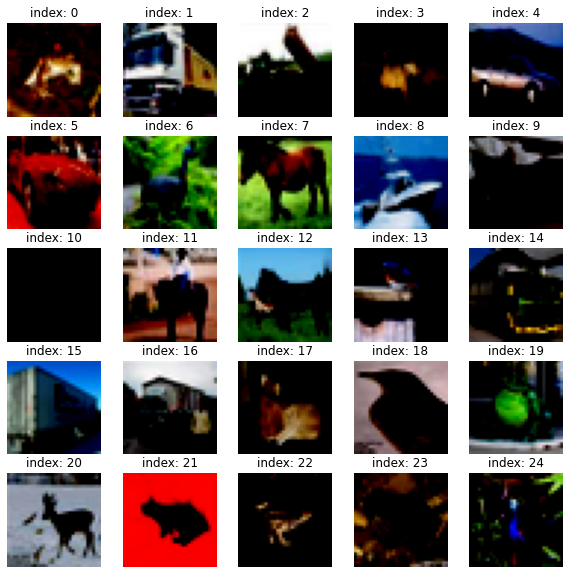

In [6]:
# 전체 프레임의 크기 설정
plt.figure(figsize=(10, 10))

# 0~24까지 반복
for i in range(25):
    # 2행 5열의 인덱스 생성
    plt.subplot(5, 5, i+1)
    # 이미지 데이터를 32X32크기의 컬러 이미지로 출력
    plt.imshow(train_x[i])
    # 각 이미지의 제목 지정
    plt.title(f'index: {i}')
    # 축 정보 제거
    plt.axis('off')
plt.show()

In [7]:
# 전체 데이터를 섞기 위한 버퍼 설정
BUFFER_SIZE = 50000
# 배치 크기 설정
BATCH_SIZE = 256

전체 데이터를 섞기 위해 총 학습 데이터의 개수인 50,000으로 버퍼를 설정하도록 한다.

In [8]:
# 전체 데이터를 섞고, 지정된 범위로 미니 배치 생성
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

설정된 버퍼로 데이터를 섞고, 지정된 배치 크기로 데이터셋의 미니배치를 생성한다.  
추후 모델학습을 진행할 때 `train_dataset`으로 학습을 진행해야하는 것에 유의하도록 한다.

### STEP4. 생성자 모델 구현하기
---
개요에서 설명한대로 데이터셋 형상의 차이에 유의하며 CIFAR-10 데이터셋의 형상에 맞는 생성자 모델을 구현하는 함수를 작성한다.  
생성자 함수 정의가 끝나면 랜덤한 노이즈를 입력으로 하여 랜덤 이미지가 생성자 출력 규격에 맞는지 그 출력 결과를 확인한다.

In [9]:
# 생성자 모델 함수 정의
def make_generator_model():
    # Sequential 모델 객체 생성
    model = tf.keras.Sequential()
    
    # Dense 레이어 추가
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    # 배치 정규화 레이어 추가
    model.add(layers.BatchNormalization())
    # 횔성화 함수 레이어 추가
    model.add(layers.LeakyReLU())
    
    # 형상 변경
    model.add(layers.Reshape((8, 8, 256)))
    # output 텐서 형상 확인
    assert model.output_shape == (None, 8, 8, 256)
    
    #Convolution 업샘플링 레이어 추가
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    # output 텐서 형상 확인
    assert model.output_shape == (None, 8, 8, 128)
    # 배치 정규화 레이어 추가
    model.add(layers.BatchNormalization())
    # 활성화 함수 레이어 추가
    model.add(layers.LeakyReLU())
    
    # Convolution 업샘플링 레이어 추가
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    # output 텐서 형상 확인
    assert model.output_shape == (None, 16, 16, 64)
    # 배치 정규화 레이어 추가
    model.add(layers.BatchNormalization())
    # 활성화 함수 레이어 추가
    model.add(layers.LeakyReLU())
    
    # 결과 출력 Convolution 업샘플링 레이어 추가
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    
    return model

Conv2DTranspose 레이어는 일반적인 Convolution 레이어와는 반대로 이미지 사이즈를 넓여주는 업샘플링 작업을 진행한다.  
위의 모델에서는 3번의 Conv2DTranspose 레이어를 통해 이미지의 크기를 `(8, 8, 256) -> (16, 16, 64) -> (32, 32, 3)`의 형태로 키워나간다.  
레이어의 사이사이에는 가중치가 폭발하지 않도록 배치 정규화 레이어를 추가하여 가중치 값을 정규화 시킨다.  
또한 중간층과는 다르게 마지막 층의 활성화 함수로 tanh를 사용하는 이유는 픽셀값을 -1~1사이로 정규화시켰던 데이터셋과 같이 출력 값을 동일하게 하기 위함이다.

In [10]:
# 생성자 모델 생성
generator = make_generator_model()
# 모델 구조 확인
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1638400   
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0

출력 데이터의 형상이 데이터셋 이미지와 같이 (32, 32, 3) 형상으로 출력되는 것을 확인할 수 있다.

In [11]:
# 1부터 100까지의 난수로 노이즈 생성
noise = tf.random.normal([1,100])

In [12]:
# 노이즈 데이터를 모델에 입력
generated_image = generator(noise, training=False)
# 출력 결과 확인
generated_image.shape

TensorShape([1, 32, 32, 3])

아직 모델을 학습시키기 전이라서 의미 있는 결과가 출력되지는 않겠지만, 출력 규격에 맞는 간단한 이미지가 생성되었다.    
지금은 학습을 시키는 과정이 아니므로 BatchNormalization의 훈련시기와 추론시기의 행동 차이를 고려해서 `training=False`로 설정하도록 한다.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


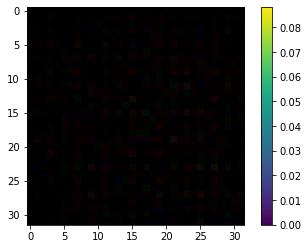

In [13]:
# 0번째 축의 값을 0으로 변환하여 시각화
plt.imshow(generated_image[0, :, :, :], cmap='viridis')
plt.colorbar()
plt.show()

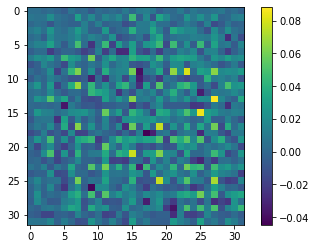

In [14]:
plt.imshow(generated_image[0, :, :, 0], cmap='viridis')
plt.colorbar()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


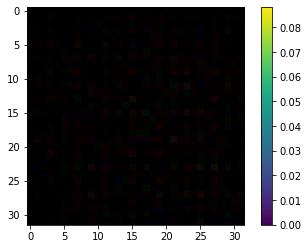

In [15]:
plt.imshow(generated_image[0, :, :, :])
plt.colorbar()
plt.show()

`generated_image`의 네 번째 차원은 컬러 채널이므로 0으로 하게 되면 첫 번째 채널에 대한 정보만 출력하게 되므로 0이 아닌 ':'으로 전체 채널에 대한 정보를 출력할 수 있게끔 설정해야 한다. 또한, `cmap`은 흑백 이미지를 시각화하기 위한 요소로써 컬러 이미지의 경우에는 `cmap`을 생략해도 된다.

### STEP 5. 판별자 모델 구현하기
---
(32, 32, 3)형상의 이미지를 입력으로 받아 1dim을 판별 결과로 출력하는 판별자 몯겔 구현 함수를 정의해보도록 한다.  
모델 정의가 끝나면 위에서 생성한 랜덤 이미지를 판별자 모델이 판별한 결과를 확인해본다.

In [16]:
# 판별자 모델 정의
def make_discriminator_model():
    # Sequential 모델 객체 생성
    model = tf.keras.Sequential()
    
    # Convolution 레이어 추가
    model.add(layers.Conv2D(64, (5,5), strides=(2,2), padding='same', input_shape=[32,32,3]))
    # 활성화 함수로 LeakyReLU 사용
    model.add(layers.LeakyReLU())
    # 드롭아웃으로 전체 뉴런의 70%만 학습에 참여
    model.add(layers.Dropout(0.3))
    
    # Convolution 레이어 추가
    model.add(layers.Conv2D(128, (5,5), strides=(2,2), padding='same'))
    # 활성화 함수로 LeakyReLU 사용
    model.add(layers.LeakyReLU())
    # 드롭아웃으로 전체 뉴런의 70%만 학습에 참여
    model.add(layers.Dropout(0.3))
    
    # 플래튼 레이어 추가
    model.add(layers.Flatten())
    # 덴스 레이어 추가
    model.add(layers.Dense(1))
    
    return model

판별자는 생성자와는 다르게 이미지의 크기를 줄여나가며 학습을 진행하며 이미지의 크기가 `(32, 32, 3) -> (16, 16, 64) -> (8, 8, 128)`로 축소하게 된다.  
마지막에는 `Flatten`레이어를 통해 3차원 이미지를 1차원 벡터로 전개를 하면서 8X8X128 = 8192, 즉 (1, 8192)형상의 벡터로 변환이 된다.

In [17]:
# 판별자 모델 생성
discriminator = make_discriminator_model()
# 판별자 모델 구조 확인
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)             

In [18]:
# 판별자 모델에 랜덤 이미지 입력
decision = discriminator(generated_image, training=False)
# 그 출력을 확인
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00470723]], dtype=float32)>

아무 의미 없는 데이터가 출력이 되었다.

### STEP 6. 손실 함수와 최적화 함수 구현하기
---
딥러닝 모델이 학습을 하기 위해서는 손실함수와 최적화함수가 필요하다.  
여기서 GAN은 손실함수로 교차 엔트로피를 사용하는데 그 이유는 판별자가 한 개의 이미지가 진짜인지 가짜인지 나타내는 2개 클래스 간 분류 문제를 풀어야 하기 때문이다.  
Real Image에 대한 레이블을 1, Fake Image에 대한 레이블을 0으로 두었을 때, 각각의 손실함수를 이용해 정량적으로 달성해야 하는 목표하는 결과는 다음과 같다.  
* 생성자: 판별자가 Fake Image에 대해 판별한 값, 즉 `D(fake_image)`값이 1에 가까워 지는 것
* 판별자: Real Image 판별값, 즉 `D(real_image)`값이 1에, Fake Image 판별값, 즉 `D(fake_image)`값이 0에 가까워지는 것

유의해야 할 점은 위에서 설계한 판별자 모델엔 sigmoid나 tanh과 같은 값을 정규화시키는 활성화 함수가 없어 그 출력값은 범위가 지정되지 않은 실수값들이다. 하지만, `tf.keras.losses`에서 제공하는 교차 엔트로피 함수는 본인에게 들어오는 input 값의 범위가 0-1 사이에 분포하는 확률값이라고 가정을 하기 때문에 `from_logits`를 `True`로 설정을 해주어야 `BinaryCrossEntropy`에 입력된 값을 함수 내부에서 sigmoid 함수를 사용해 0-1 사이의 값으로 정규화한 후, 올바르게 계산을 하게 된다.  

또한, 판별자가 real_output과 fake_output을 얼마나 정확히 판별하는지의 accuracy를 계산해보는 것도 GAN의 학습에서는 매우 중요하다. 특히 두 결과의 accuracy를 따로 계산해서 비교하는 작업이 매우 유용하다.  
이 때, 판별자가 real_output과 fake_output의 accuracy를 1.0에 가까울 정도로 정확하게 판별해 내는 것은 모델의 성능이 좋은 것이 아니라 생성자가 만들어낸 fake_output이 real_output과 차이가 많이 나기 때문에 판별자가 너무 쉽게 잡아낸다는 것을 의미한다. 그래서 real accuracy와 fake accuracy는 초반에 1.0에 가깝게 나오다가, 서서히 낮아져서 둘 다 0.5에 가까워지는 것이 이상적이다. fake accuracy가 1.0에 가깝다면 아직은 생성자가 판별자를 잘 속이지 못하고 있다는 것을 의미한다.  

<br>

이번 스텝에서 구현해야 할 목록은 다음과 같다.
* 생성자와 판별자의 손실함수(loss) 구현
* 판별자의 출력값을 가지고 실제/생성(real/fake) 이미지 판별 정확도(accuracy)를 계산하는 함수 구현
* 생성자와 판별자를 최적화하는 optimizer 정의

In [19]:
# cross entropy 손실함수 정의
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

생성자가 만들어낸 이미지의 True/False 여부를 판단해야 하기에 이진분류 교차 엔트로피 손실함수를 사용한다.

In [20]:
# 생성자 손실 함수 정의
def generator_loss(fake_output):
    # 비교 대상을 fake_output과 크기가 같고 1로 채워진 텐서로 지정
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [21]:
# 판별자 손실 함수 정의
def discriminator_loss(real_output, fake_output):
    # 비교 대상을 real_output과 크기가 같고 1로 채워진 텐서로 지정
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    # 비교 대상을 fake_output과 크기가 같고 0으로 채워진 텐서로 지정
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    
    # 두 loss의 합
    total_loss = real_loss + fake_loss
    
    return total_loss

In [22]:
def discriminator_accuracy(real_output, fake_output):
    # real_output의 값이 0.5 이상인지의 여부를 나타내는 0과 1의 불리언 값으로 정확도 계산
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    # fake_output의 값이 0.5 미만인지의 여부를 나타내는 0과 1의 불리언 값으로 정확도 계산
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    
    return real_accuracy, fake_accuracy

`real_output = tf.Tensor([0.1, 0.7, 0.5, 0.9])` 라면, 연산 순서는 다음과 같다.
* (1) tf.math.greater_equal(real_output, tf.constant([0.5]) : real_output의 각 원소가 0.5 이상인지 True, False로 판별
    * `>>> tf.Tensor([False, True, True, True])`
* (2) tf.cast((1), tf.float32) : (1)의 결과가 True이면 1.0, False이면 0.0으로 변환
    * `>>> tf.Tensor([0.0, 1.0, 1.0, 1.0])`
* (3) tf.reduce_mean((2)) : (2)의 결과를 평균내어 이번 배치의 정확도(accuracy)를 계산
    * `>>> 0.75`

In [23]:
# 생성자 옵티마이저를 Adam으로 정의하고 학습률을 매우 작은 값으로 지정
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
# 판별자 옵티마이저를 Adam으로 정의하고 학습률을 매우 작은 값으로 지정
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

최적화 함수는 Adam 최적화 기법을 사용하고, 생성자와 판별자는 별개의 네트워크이기 때문에 optimizer를 따로 정의해야 한다는 점에 유의한다.

### STEP 7. 훈련 과정 상세 기능 구현하기
---
모델 학습 과정을 시각적으로 확인하기 위해 1개 미니배치의 학습 과정을 처리하는 함수를 정의하고, 훈련 진행에 따른 생성된 이미지의 변화를 파악하기 위해 고정된 seed를 입력으로 하여 학습 과정 동안 생성한 이미지를 시각화하는 함수도 정의한다.  
학습 epochs마다 생성자와 판별자의 loss 및 판별자의 real/fake 이미지 판별 정확도 히스토리를 시각화하는 함수를 정의한다.  
마지막으로, epoch마다 최적의 모델을 저장하는 checkpoint 모듈을 설정하도록 한다.

In [24]:
# 샘플 차원 수 지정
noise_dim = 100
# 한 번에 만들 샘플 수 지정
num_examples_to_generate = 16

# 지정된 값으로 무작위값을 가진 노이즈 생성
seed = tf.random.normal([num_examples_to_generate, noise_dim])
# 생성된 노이즈 형상 확인
seed.shape

TensorShape([16, 100])

학습 진행을 확인하기 위해 생성할 샘플은 매번 같은 노이즈로 생성해야 그에 대한 진전 과정을 확인할 수 있으므로 고정된 seed 노이즈를 만들어두도록 한다.  샘플은 한 번에 16개씩 만들 것이고, 그렇게 되면 100차원의 노이즈를 16개, 즉 `(16, 100)`형상의 벡터를 만들게 되는 것이다.

In [25]:
# 데코레이터 함수 지정
@tf.function
def train_step(images):
    # 생성자 입력 노이즈
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    # 생성자와 판별자의 기울기를 기록할 수 있는 테이프 오픈
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # 생성자로 입력 노이즈를 활용하여 fake image 생성
        generated_images = generator(noise, training=True)
        
        # real image를 판별자에 입력하여 그 결과 저장
        real_output = discriminator(images, training=True)
        # fake image를 판별자에 입력하여 그 결과 저장
        fake_output = discriminator(generated_images, training=True)
        
        # fake image에 대한 생성자 손실함수 값 저장
        gen_loss = generator_loss(fake_output)
        # real/fake image에 대한 판별자 손실함수 값 저장
        disc_loss = discriminator_loss(real_output, fake_output)
        
        # real/fake image에 대한 판별자의 정확도 저장
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output)
        
    # 생성자의 기울기 변화 기록
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    # 판별자의 기울기 변화 기록
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # 생성자의 기울기에 대한 최적화 작업 진행
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    # 판별자의 기울기에 대한 최적화 작업 진행
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    # 생성자의 손실함수 값, 판별자의 손실함수 값, 실제 이미지의 정확도, 가짜 이미지의 정확도 리턴
    return gen_loss, disc_loss, real_accuracy, fake_accuracy

* (1) 입력 데이터: Real Image 역할을 할 `images` 한 세트를 입력으로 받음
* (2) 생성자 입력 노이즈 : generator가 FAKE IMAGE를 생성하기 위한 `noise`를 `images` 한 세트와 같은 크기인 `BATCH_SIZE` 만큼 생성함
* (3) `tf.GradientTape()`는 가중치 갱신을 위한 Gradient를 자동 미분으로 계산하기 위해 `with` 구문 열기
* (4) generated_images 생성 : generator가 `noise`를 입력받은 후 `generated_images` 생성
* (5) discriminator 판별 : discriminator가 Real Image인 `images`와 Fake Image인 `generated_images`를 각각 입력받은 후 `real_output`, `fake_output` 출력
* (6) loss 계산 : `fake_output`, `real_output`으로 generator와 discriminator 각각의 loss 계산
* (7) accuracy 계산 : `fake_output`, `real_output`으로 discriminator의 정확도 계산
* (8) gradient 계산 : `gen_tape`와 `disc_tape`를 활용해 gradient를 자동으로 계산
* (9) 모델 학습 : 계산된 gradient를 optimizer에 입력해 가중치 갱신
* (10) 리턴값 : 이번 스텝에 계산된 loss와 accuracy를 리턴

In [26]:
# 학습 현황을 볼 수 있는 샘플을 생성하는 함수 정의
def generate_and_save_images(model, epoch, it, sample_seeds):
    # 고정된 seed에 대한 결과 저장
    predictions = model(sample_seeds, training=False)
    
    # 4X4 크기의 프레임 정의
    fig = plt.figure(figsize=(4,4))
    
    # predictions의 크기만큼 반복
    for i in range(predictions.shape[0]):
        # 4행 4열의 인덱스 별 서브 프레임 생성
        plt.subplot(4, 4, i+1)
        img = predictions[i].numpy()
        img = (img* 127.5) + 127.5
        img = img.astype(int)
        # 그래프 그리기
        plt.imshow(img)
        # 축 정보 비노출
        plt.axis('off')
        
    # 생성된 프레임을 해당 경로에 png파일로 저장
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))
    
    # 프레임 보이기
    plt.show()

In [27]:
from matplotlib.pylab import rcParams

# matlab 차트의 기본 크기를 15,6으로 지정
rcParams['figure.figsize'] = 15, 6

# 히스토리를 시각화하는 함수 정의
def draw_train_history(history, epoch):
    # 손실함수 값에 대한 그래프 영역 할당
    plt.subplot(211)  
    # 생성자 손실 함수 값 리스트
    plt.plot(history['gen_loss'])  
    # 판별자 손실 함수 값 리스트
    plt.plot(history['disc_loss'])
    # 그래프 제목
    plt.title('model loss')  
    # y축 레이블
    plt.ylabel('loss')  
    # x축 레이블
    plt.xlabel('batch iters')  
    # 좌측 상단에 생성자 손실 함수 값 범례와 판별자 손실 함수 값 범례 추가
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # 정확도 값에 대한 그래프 영역 할당
    plt.subplot(212)  
    # 가짜 이미지 정확도 리스트
    plt.plot(history['fake_accuracy'])  
    # 진짜 이미지 정확도 리스트
    plt.plot(history['real_accuracy'])  
    # 그래프 제목
    plt.title('discriminator accuracy')  
    # y축 레이블
    plt.ylabel('accuracy')  
    # x축 레이블
    plt.xlabel('batch iters')  
    # 좌측 상단에 가짜 이미지 정확도 범례와 진짜 이미지 정확도 범례 추가
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    # 그래프 보이기
    plt.show()

`train_step()`함수가 리턴하는 `gen_loss`,`disc_loss`,`real_accuracy`,`fake_accuracy`의 값을 저장하고 있는 딕셔너리를 만들고 매 epoch마다 시각화하는 함수를 만들어 학습 경과에 따른 각 지표의 흐름을 파악하도록 한다.

In [28]:
# 모델 저장 경로 지정
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

# 모델 저장 디렉터리 지정
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
# 각 모델의 옵티마이저와 가중치 저장
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

모델이 복잡해지고, 학습이 오래 걸릴수록 해당 시점의 모델을 저장 혹은 버전 관리를 하는 것은 필수적이다. checkpoint에 optimizer와 생성자/판별자가 학습한 모델의 가중치를 저장하도록 한다.

### STEP 8. 학습 과정 진행하기
---
epochs를 지정하여 모델을 학습 시키고, 학습 과정에서 생성된 샘플 이미지로 만든 gif 파일을 통해 학습 진행과정을 시각적으로 표현해본다.

In [29]:
# 모델 학습 함수 정의
def train(dataset, epochs, save_every):
    # 학습 시작 시간
    start = time.time()
    # 히스토리 딕셔너리 초기화
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}
    
    # 설정한 에폭만큼 학습 반복
    for epoch in range(epochs):
        # 각 에폭 시작 시간
        epoch_start = time.time()
        # 데이터셋의 크기만큼 반복
        for it, image_batch in enumerate(dataset):
            # 생성자 손실함수 값, 판별자 손실함수 값, 실제 이미지 정확도, 가짜 이미지 정확도 반환
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            
            # 각각의 변수에 든 값을 히스토리 딕셔너리에 리스트로 저장
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)
            
            # 배치 인덱스가 50의 배수가 될 때마다
            if it % 50 == 0:
                # 화면 초기화
                display.clear_output(wait=True)
                # 고정된 seed를 통해 생성된 이미지 저장
                generate_and_save_images(generator, epoch+1, it+1, seed)
                # 에폭과 배치 순서 출력
                print('Epoch {} | iter {}'.format(epoch+1,it+1))
                # 에폭에 소요된 시간 출력
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))
                
        # 모델 저장 간격
        if (epoch + 1) % save_every == 0:
            # 모델 저장
            checkpoint.save(file_prefix=checkpoint_prefix)
            
        # 화면 초기화
        display.clear_output(wait=True)
        # 고정된 seed를 통해 생성된 이미지 저장
        generate_and_save_images(generator, epochs, it, seed)
        # 학습에 소요된 시간 출력
        print('Time for trainig : {} sec'.format(int(time.time()-start)))
        
        # 에폭 별 학습 결과 추이 그래프 그리기
        draw_train_history(history, epoch)

지정된 epochs와 배치를 반복하며 학습을 진행하고, 학습 진행 경과에 따른 결과 추이를 시각화하는 `train`함수를 정의했다.

In [30]:
# 에폭 진행 5회마다 모델 저장
save_every = 5
# 에폭 50회 반복
EPOCHS = 50

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

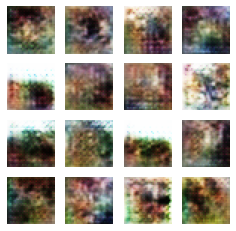

Time for trainig : 756 sec


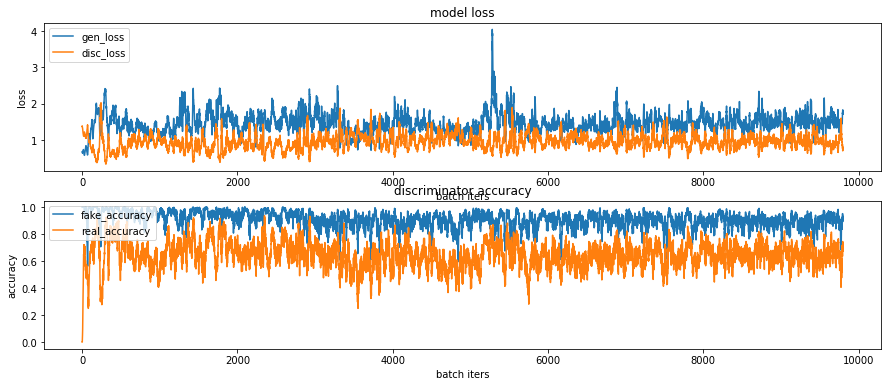

CPU times: user 12min 53s, sys: 1min 19s, total: 14min 13s
Wall time: 12min 37s


In [31]:
%%time
# 학습 시작
train(train_dataset, EPOCHS, save_every)

In [32]:
# GIF 파일 저장 경로 지정
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar_dcgan.gif'

# 'I' 모드는 이미지를 인덱스 기반의 이미지로 저장하는 모드
# with 문을 사용하여 writer를 자동으로 닫음
with imageio.get_writer(anim_file, mode='I') as writer:
    # 저장될 파일명 경로지정
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    # 저장된 파일명들을 리스트에 저장
    filenames = sorted(filenames)
    last = -1
    # 찾은 파일명을 순차적으로 인덱스와 함께 반복
    for i, filename in enumerate(filenames):
        # 이미지를 추출할 프레임을 지정하여 계산
        frame = 2*(i**0.5)
        # 각 값을 반올림하여 이미지를 추출할 프레임인지 판단
        if round(frame) > round(last):
            last = frame
        else:
            continue
        # 이미지 파일 읽기
        image = imageio.imread(filename)
        # 읽어온 이미지 파일을 GIF에 추가
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

# 애니메이션 파일 확인
!ls -l ~/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif

-rw-r--r-- 1 root root 1078175 Jan 22 09:14 /aiffel/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif


학습 결과 gif파일을 확인했는데 결과 이미지가 그닥 뚜렷하지 않다. 문제점을 파악하고 해결해보는 시간을 가져보도록 한다.

### STEP 9. (optional) GAN 훈련 과정 개선하기
---
STEP 8.까지 진행하면서 생성된 샘플 이미지, 시각화 자료 등을 참고하여 현재 모델의 성능을 평가하고, 문제점이 있다면 해당 사항에 대해 분석해보도록 한다.

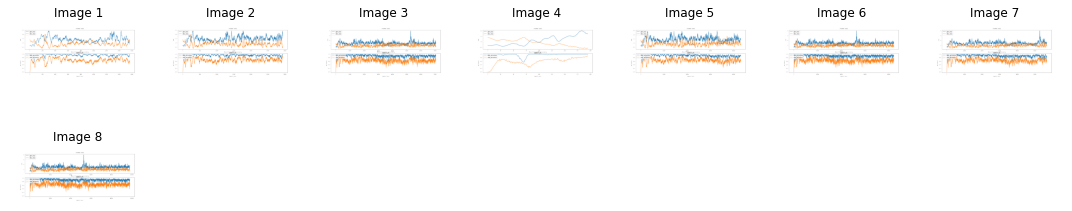

In [44]:
# 히스토리 파일이 저장된 디렉토리 경로
history_dir = os.getenv('HOME') + '/aiffel/dcgan_newimage/cifar10/training_history'

# 일부 인덱스 파일들을 저장할 리스트
selected_files = []

# 해당 경로에 있는 모든 파일을 반복
for filename in os.listdir(history_dir):
    # 파일 이름이 train_history로 시작하고 .png로 끝나는 파일만
    if filename.startswith('train_history_') and filename.endswith('.png'):
        # 파일 인덱스 부분 추출 후, 정수화
        index = int(filename.split('_')[-1].split('.')[0])
        # 7의 배수인 경우
        if index % 7 == 0:
            # 리스트에 추가
            selected_files.append(os.path.join(history_dir, filename))

# 선택된 파일들을 시각화 프레임 크기 지정
num_rows = len(selected_files) // 7 + 1
plt.figure(figsize=(15, num_rows * 2))

for i, filename in enumerate(selected_files, 1):
    plt.subplot(num_rows, 7, i)
    img = plt.imread(filename)
    plt.imshow(img)
    plt.title(f'Image {i}')
    plt.axis('off')  # 축 숨김

plt.tight_layout()
plt.show()

그래프가 너무 작다. 더 크게 출력해서 확인해보도록 한다.

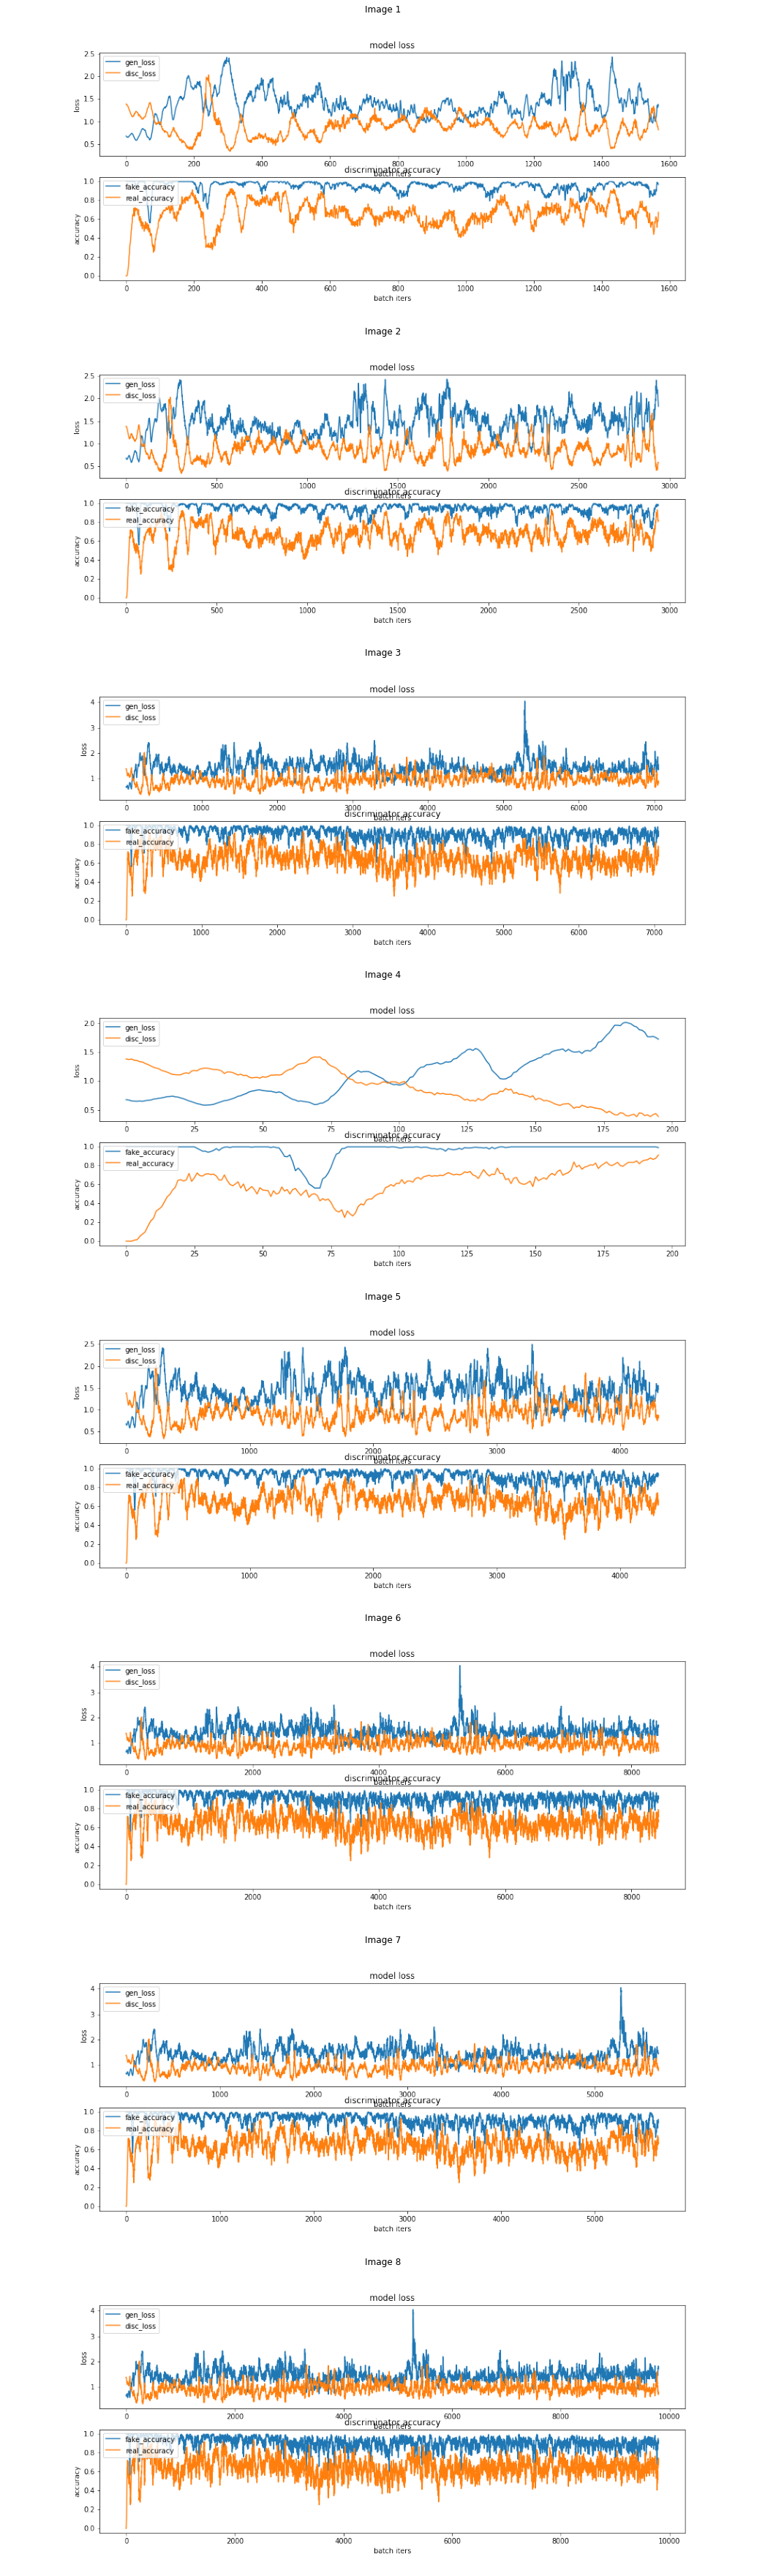

In [45]:
# num_rows = len(selected_files) // 7 + 1
fig, axes = plt.subplots(8, 1, figsize=(60, 49))

for i, filename in enumerate(selected_files, 1):
    ax = axes.flatten()[i - 1]
    img = plt.imread(filename)
    ax.imshow(img)
    ax.set_title(f'Image {i}')
    ax.axis('off')

plt.tight_layout()
plt.show()

* loss
> 에폭이 진행됨에 따라 생성자의 loss와 판별자의 loss가 서로 교차하는 횟수, 수렴 정도가 높아지는 것으로 보아 생성자와 판별자가 양질의 경쟁을 하고 있다는 것을 확인할 수 있다.
* accuracy
> fake accuracy와 real accuracy 모두 1.0에 가깝게 출력이 되고 있다. 둘 다 0.5에 가까워야 좋은 성능의 GAN이라고 하는 것을 보아 모델을 조금 수정해야할 것 같다.  

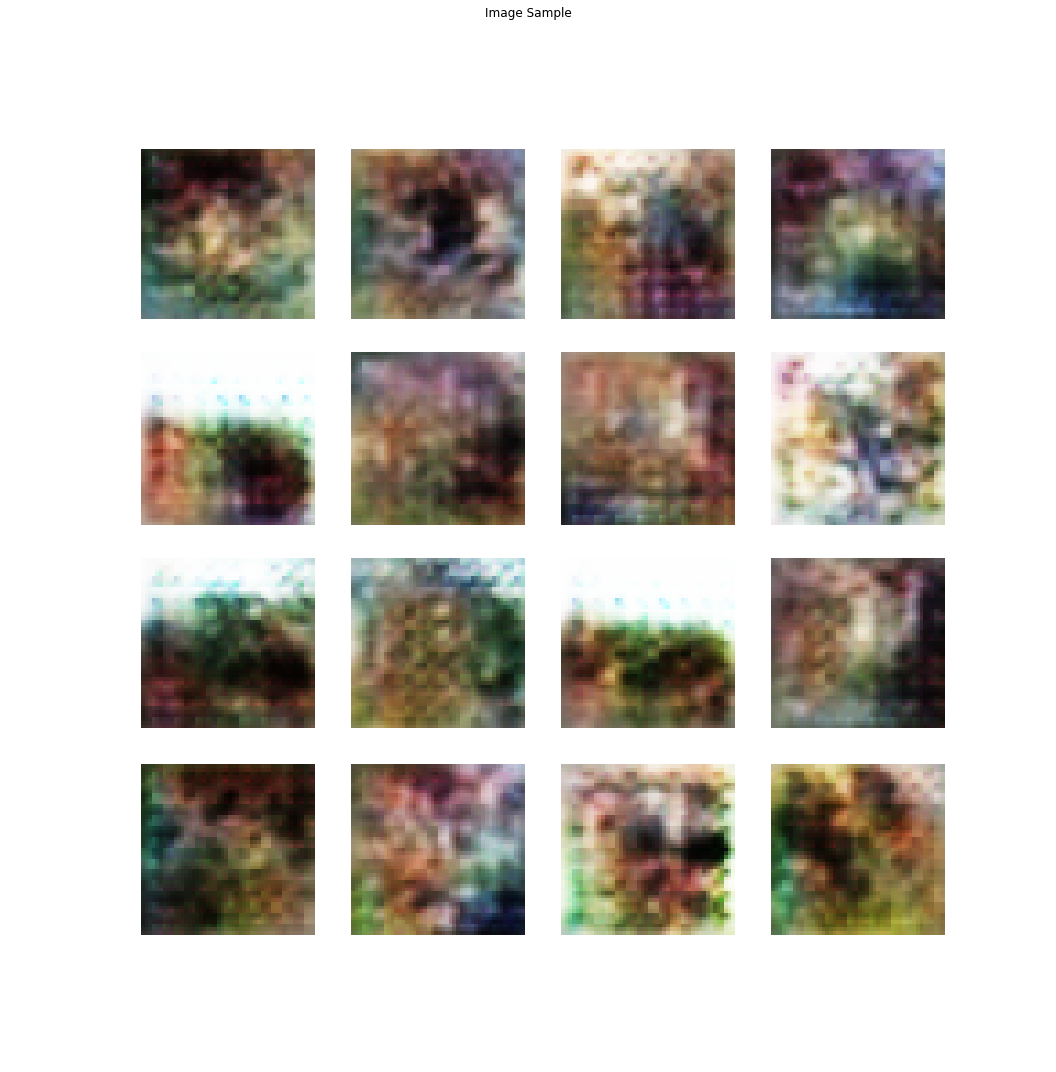

In [47]:
# 샘플 파일이 저장된 디렉토리 경로
sample_dir = os.getenv('HOME') + '/aiffel/dcgan_newimage/cifar10/generated_samples'

filename = os.path.join(sample_dir, 'sample_epoch_0050_iter_195.png')

plt.figure(figsize=(15, 15))

img = plt.imread(filename)
plt.imshow(img)
plt.title(f'Image Sample')
plt.axis('off')

plt.tight_layout()
plt.show()

샘플 이미지도 선명하지 않은 것으로 확인된다.

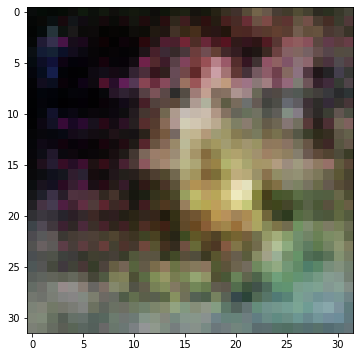

In [48]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

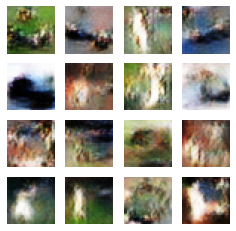

Time for trainig : 3143 sec


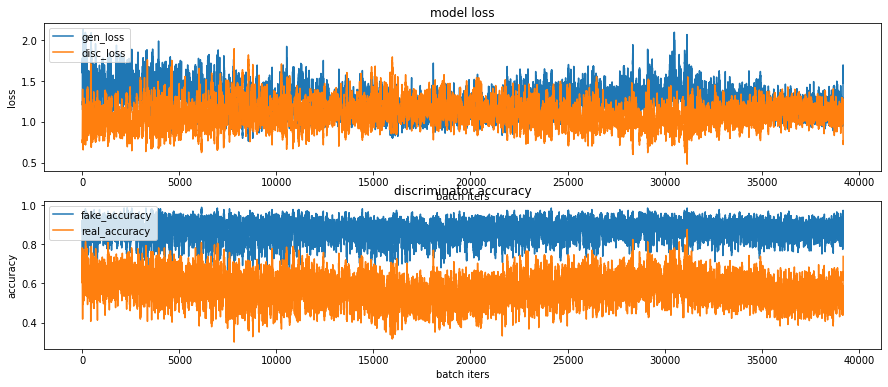

CPU times: user 53min 35s, sys: 5min 21s, total: 58min 56s
Wall time: 52min 25s


In [49]:
%%time
# 에폭 증가
EPOCHS = 200
train(train_dataset, EPOCHS, save_every)

최적화되어 저장된 모델에 에폭을 비약적으로 증가시켜 학습을 진행시켜 보도록 한다.

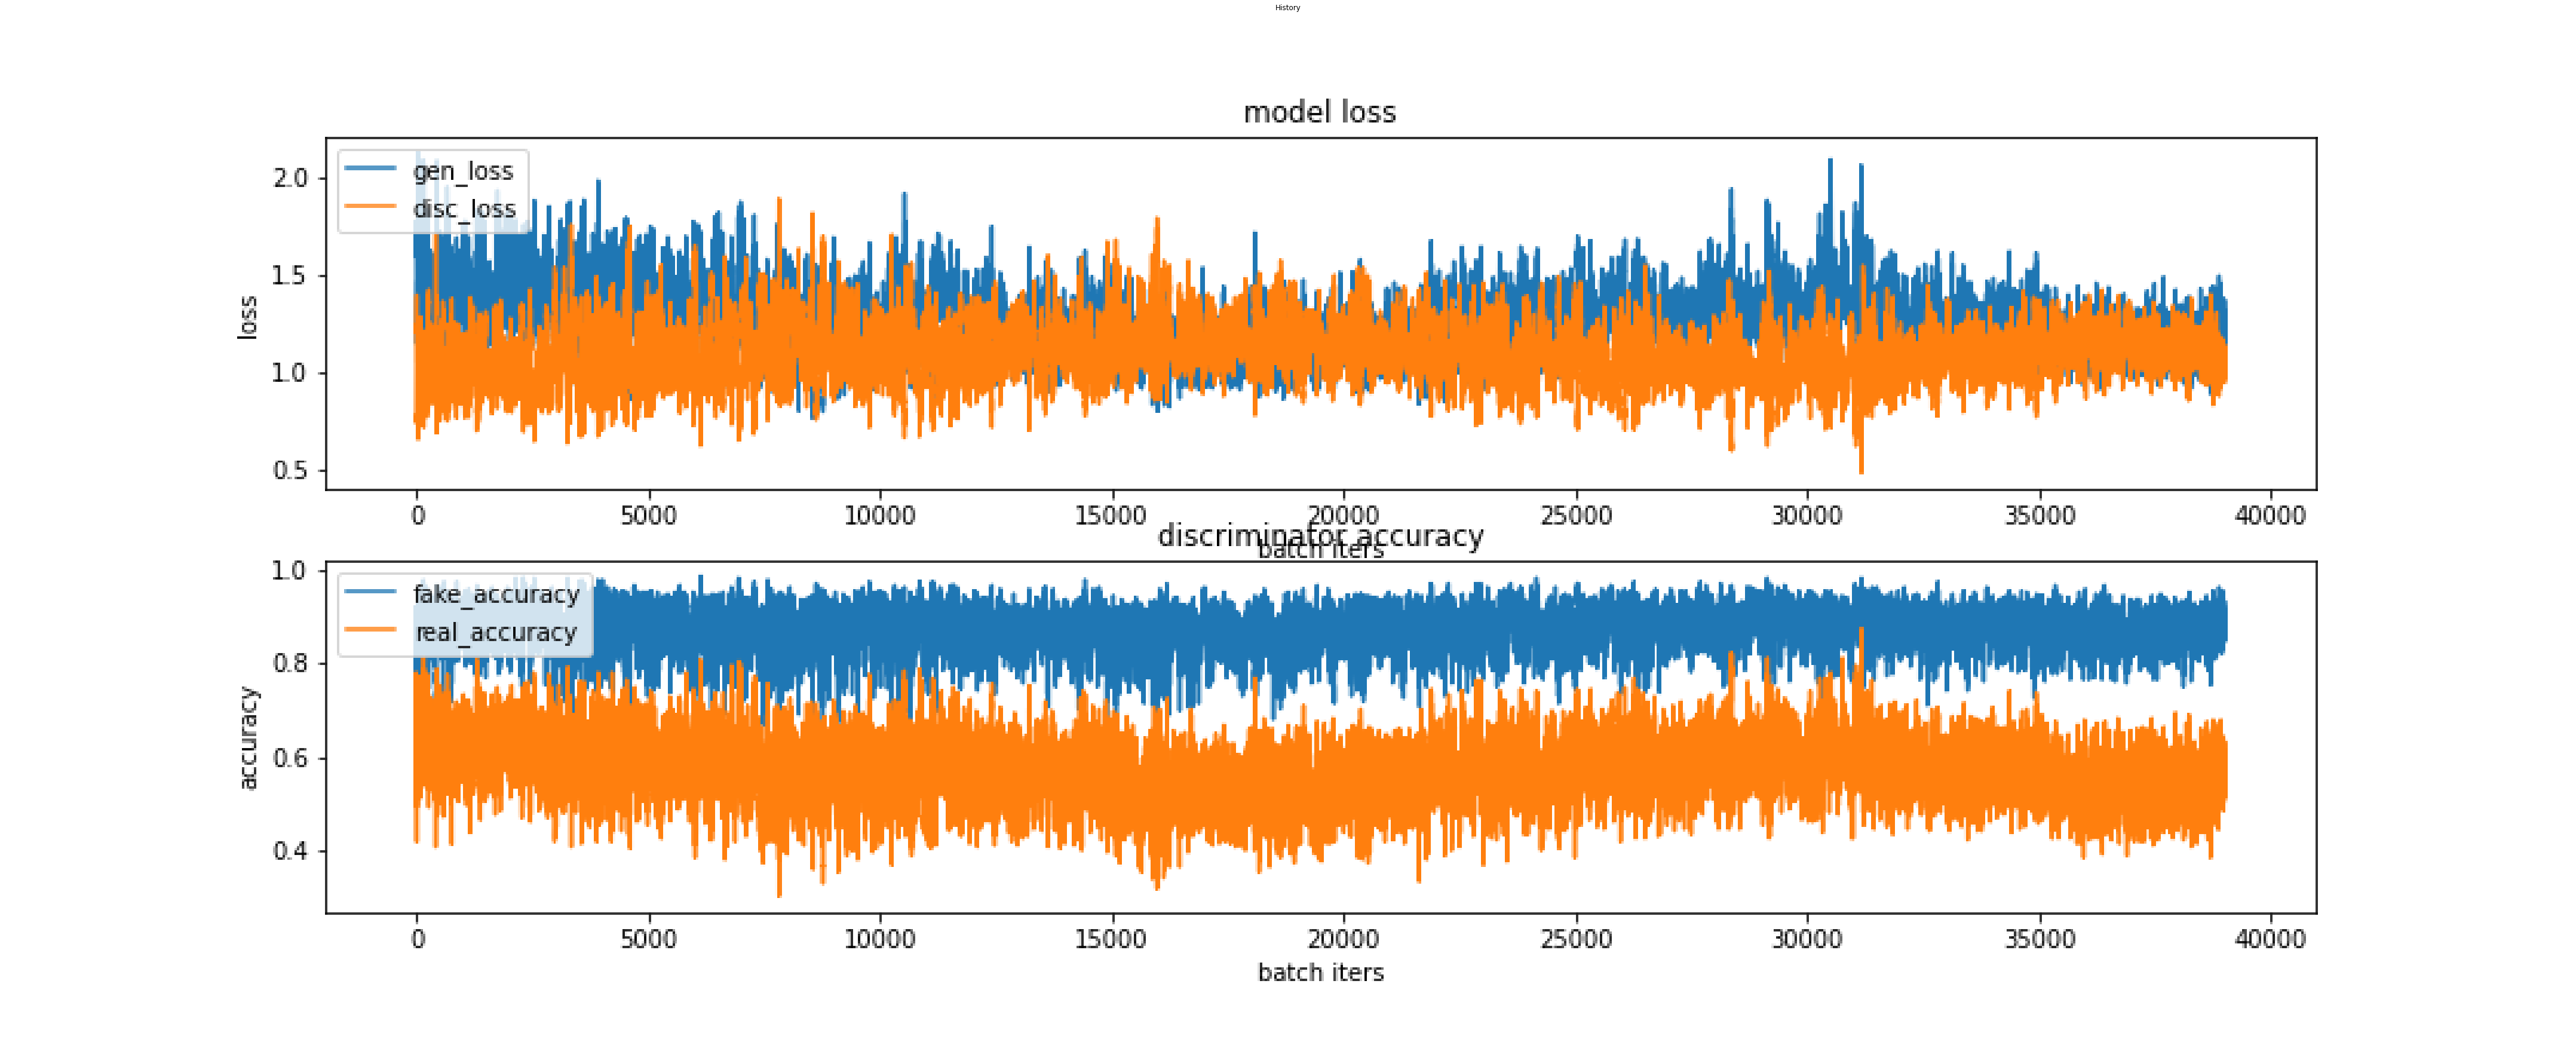

In [54]:
# 히스토리 확인
history_dir = os.getenv('HOME') + '/aiffel/dcgan_newimage/cifar10/training_history'

filename = os.path.join(history_dir, 'train_history_0198.png')

plt.figure(figsize=(60, 49))

img = plt.imread(filename)
plt.imshow(img)
plt.title(f'History')
plt.axis('off')

plt.tight_layout()
plt.show()

loss에 대한 결과는 점점 향상되는 것을 확인할 수 있고, real image의 accuracy도 많이 낮아졌지만, fake image의 accuracy가 좀 처럼 떨어지지 않는 것을 확인할 수 있다.

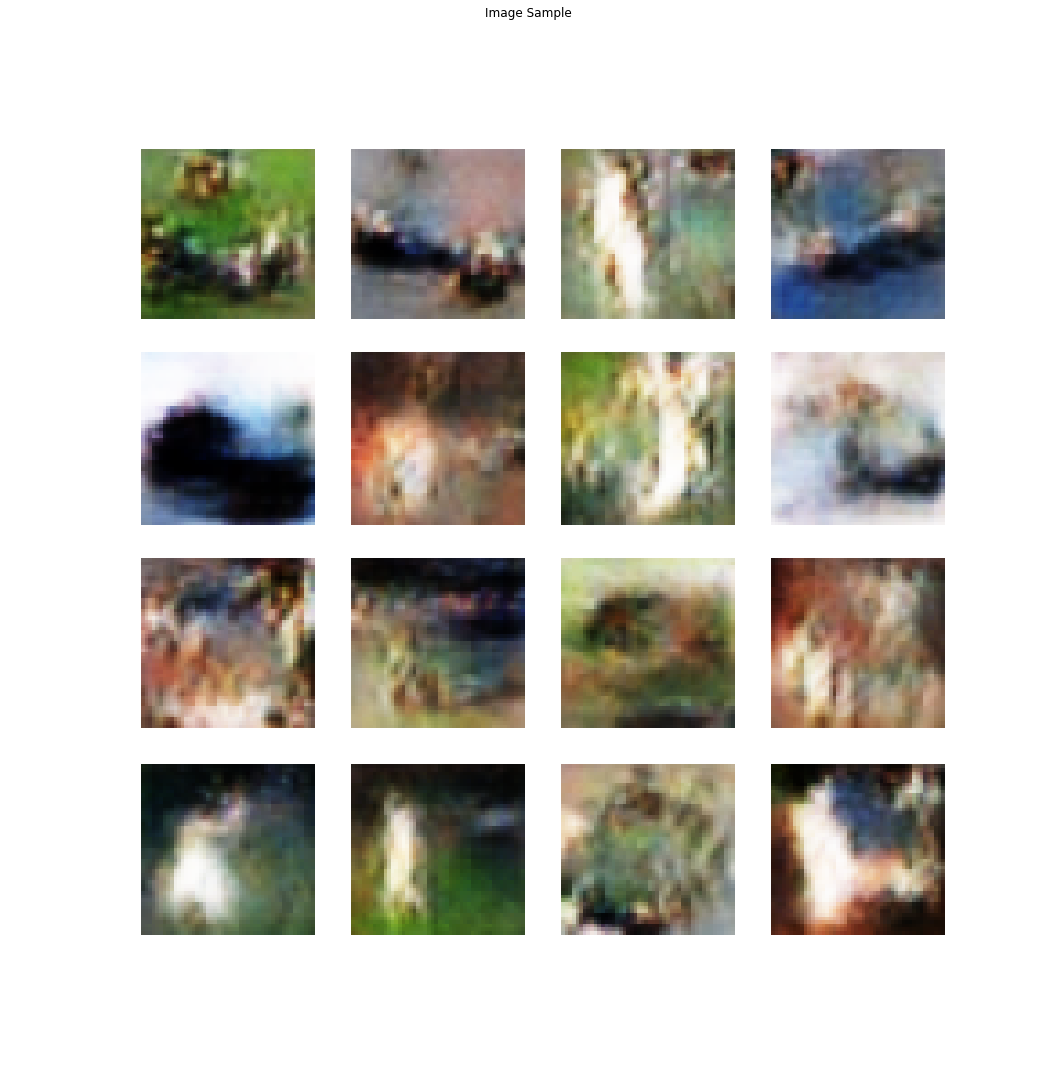

In [55]:
# 샘플 이미지 확인
sample_dir = os.getenv('HOME') + '/aiffel/dcgan_newimage/cifar10/generated_samples'

filename = os.path.join(sample_dir, 'sample_epoch_0200_iter_195.png')

plt.figure(figsize=(15, 15))

img = plt.imread(filename)
plt.imshow(img)
plt.title(f'Image Sample')
plt.axis('off')

plt.tight_layout()
plt.show()

아직도 명확하게 구분할 수는 없지만, 그래도 50에폭일 때보다는 생성 이미지가 꽤 선명해진 것을 확인할 수 있다.

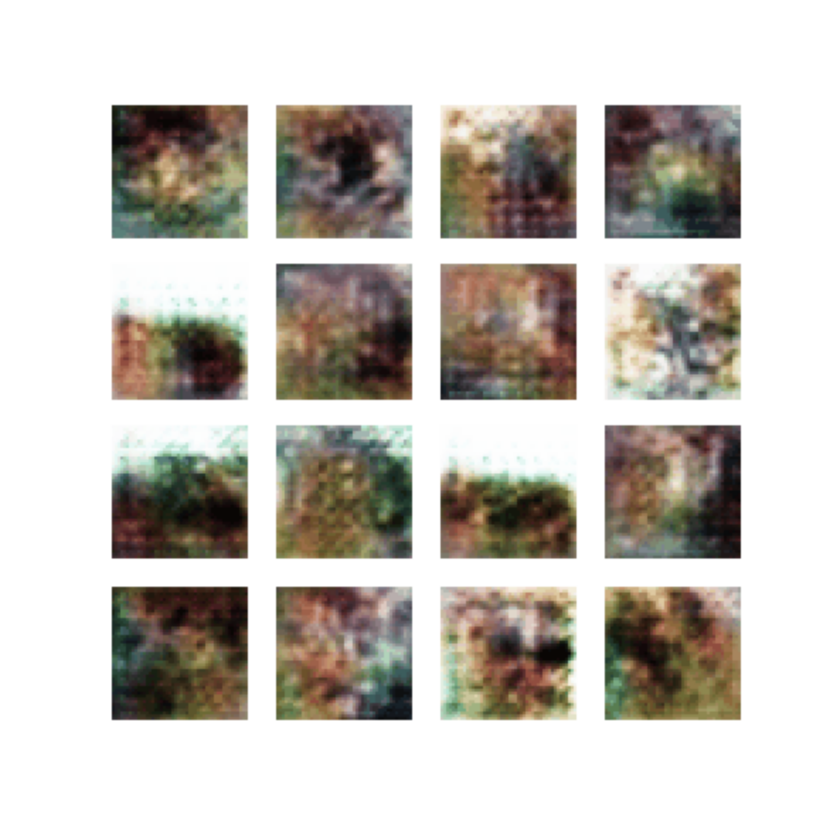

<Figure size 1080x432 with 0 Axes>

<Figure size 1080x432 with 0 Axes>

<Figure size 1080x432 with 0 Axes>

<Figure size 1080x432 with 0 Axes>

<Figure size 1080x432 with 0 Axes>

<Figure size 1080x432 with 0 Axes>

<Figure size 1080x432 with 0 Axes>

<Figure size 1080x432 with 0 Axes>

<Figure size 1080x432 with 0 Axes>

<Figure size 1080x432 with 0 Axes>

<Figure size 1080x432 with 0 Axes>

<Figure size 1080x432 with 0 Axes>

<Figure size 1080x432 with 0 Axes>

<Figure size 1080x432 with 0 Axes>

<Figure size 1080x432 with 0 Axes>

<Figure size 1080x432 with 0 Axes>

<Figure size 1080x432 with 0 Axes>

<Figure size 1080x432 with 0 Axes>

<Figure size 1080x432 with 0 Axes>

<Figure size 1080x432 with 0 Axes>

<Figure size 1080x432 with 0 Axes>

<Figure size 1080x432 with 0 Axes>

<Figure size 1080x432 with 0 Axes>

<Figure size 1080x432 with 0 Axes>

<Figure size 1080x432 with 0 Axes>

<Figure size 1080x432 with 0 Axes>

<Figure size 1080x432 with 0 Axes>

<Figure size 1080x432 with 0 Axes>

<Figure size 1080x432 with 0 Axes>

<Figure size 1080x432 with 0 Axes>

<Figure size 1080x432 with 0 Axes>

<Figure size 1080x432 with 0 Axes>

<Figure size 1080x432 with 0 Axes>

<Figure size 1080x432 with 0 Axes>

<Figure size 1080x432 with 0 Axes>

<Figure size 1080x432 with 0 Axes>

<Figure size 1080x432 with 0 Axes>

<Figure size 1080x432 with 0 Axes>

<Figure size 1080x432 with 0 Axes>

<Figure size 1080x432 with 0 Axes>

<Figure size 1080x432 with 0 Axes>

<Figure size 1080x432 with 0 Axes>

<Figure size 1080x432 with 0 Axes>

<Figure size 1080x432 with 0 Axes>

<Figure size 1080x432 with 0 Axes>

<Figure size 1080x432 with 0 Axes>

<Figure size 1080x432 with 0 Axes>

<Figure size 1080x432 with 0 Axes>

<Figure size 1080x432 with 0 Axes>

<Figure size 1080x432 with 0 Axes>

<Figure size 1080x432 with 0 Axes>

<Figure size 1080x432 with 0 Axes>

<Figure size 1080x432 with 0 Axes>

<Figure size 1080x432 with 0 Axes>

<Figure size 1080x432 with 0 Axes>

<Figure size 1080x432 with 0 Axes>

<Figure size 1080x432 with 0 Axes>

<Figure size 1080x432 with 0 Axes>

In [56]:
# GIF 파일 저장 경로 지정
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar_dcgan.gif'

# 'I' 모드는 이미지를 인덱스 기반의 이미지로 저장하는 모드
# with 문을 사용하여 writer를 자동으로 닫음
with imageio.get_writer(anim_file, mode='I') as writer:
    # 저장될 파일명 경로지정
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    # 저장된 파일명들을 리스트에 저장
    filenames = sorted(filenames)
    last = -1
    # 찾은 파일명을 순차적으로 인덱스와 함께 반복
    for i, filename in enumerate(filenames):
        # 이미지를 추출할 프레임을 지정하여 계산
        frame = 2*(i**0.5)
        # 각 값을 반올림하여 이미지를 추출할 프레임인지 판단
        if round(frame) > round(last):
            last = frame
        else:
            continue
        # 이미지 파일 읽기
        image = imageio.imread(filename)
        # 읽어온 이미지 파일을 GIF에 추가
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

# GIF 파일 로드
gif = imageio.mimread(anim_file)

# 각 프레임을 시각화
fig, ax = plt.subplots(figsize=(15, 15))
for frame in gif:
    ax.imshow(frame)
    ax.axis('off')
    plt.pause(0.1)
    plt.draw()

plt.show()

## SUMMARY
---
DGGAN 모델을 설계하여 CIFAR-10 데이터셋으로 이미지 생성 프로젝트를 진행하였다. 처음 50번의 에폭으로 학습을 진행했을 때에는 에폭이 진행됨에 따라 생성자의 loss와 판별자의 loss가 서로 교차하는 횟수도 높아지며 수렴률도 상승하였지만, 진짜 이미지의 정확도와 가짜 이미지의 정확도가 1에 가까운 수치를 보이고 생성 이미지가 선명하지 않은 문제점이 발견되었다. 시간 관계상 모델의 재구성보다는 에폭을 증가시켜 더 많은 가중치 업데이트를 진행하는 방향으로 성능 개선을 시도해봤다. 그 결과 기존의 문제점이었던 real image의 accuracy는 중앙으로 많이 수렴한 것을 확인할 수 있는 반면에 fake image의 accuracy는 좀처럼 중앙으로 수렴하지 않는 다는 것을 확인 할 수 있었다. 생성자가 만들어내는 이미지도 50 에폭의 경우보다 많이 선명해진 것을 gif 파일로 확인할 수 있었지만, 아직도 사물을 구분할 정도로 선명하지 못해 눈에 띄는 성능 개선을 이뤄냈다고 보긴 힘들 것 같다.

<br>

## 회고
---
### KEEP
* 모든 코드를 이해해가며 진행을 해서 모델 구조를 파악하는 데에 노력을 기울였다.
* 학습 결과 시각화 방법에 대해 이해하고, 시각화 자료가 의미하는 바를 분석하려 했다.  

### PROBLEM
* 데이터의 흐름에 관여하는 항목(배치 사이즈)들을 설정하는 부분에 대한 이해가 부족하다.
* 모델 성능을 개선하는 방안에 대해 충분히 분석하지 못했다.  

### TRY
* GAN을 학습할 수 있는 또 다른 데이터셋을 찾아 한 싸이클을 코딩해봐야겠다.
* 학습 결과 시각화 자료에 대한 레퍼런스를 찾아보고 테스트 케이스를 만들어 위의 시도와 병행을 할 예정이다.